https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr

from scipy.special import expit as logistic


print(f"Running on PyMC v{pm.__version__}")

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v4.0.0


https://github.com/aloctavodia/BAP/blob/master/extras/multinomial_ppcs.ipynb

In [2]:
#%load_ext watermark
#%matplotlib inline

from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
#import theano.tensor as tt
import aesara.tensor as tt
import warnings

from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [3]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = RANDOM_SEED
#rng = np.random.default_rng(RANDOM_SEED)
rng = np.random.randn(512, 200)  #reduced sample size for testing

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [4]:
print(rng.shape)
print(rng.size)


(512, 200)
102400


https://discourse.pymc.io/t/multivariate-multinomial-logistic-regression/5242/2

In [5]:
data = pd.DataFrame(rng)
# y_s = pd.Categorical(iris["TYPE"]).codes
y_s = data.iloc[:, -1].values.reshape(-1, 1)

y_obs = data.iloc[:, -1].values.reshape(-1, 1)
x_n = data.columns[:-1]
x_s = data[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s = StandardScaler().fit_transform(x_s)

x_s.shape, y_s.shape, np.unique(y_s)
ndata = x_s.shape[0]
nparam = x_s.shape[1]
nclass = len(data.iloc[:, -1].unique())

print(y_obs.shape, x_s.shape)

(512, 1) (512, 199)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alfa, beta]


Sampling 4 chains for 6_000 tune and 6_000 draw iterations (24_000 + 24_000 draws total) took 581 seconds.
The acceptance probability does not match the target. It is 0.1085, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.04585, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.001037, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.02498, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alfa, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.
The acceptance probability does not match the target. It is 0.5977, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.004946, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6214, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5003, but should be close to 0.8. Try to increase the number of tuning steps.


KeyboardInterrupt: 

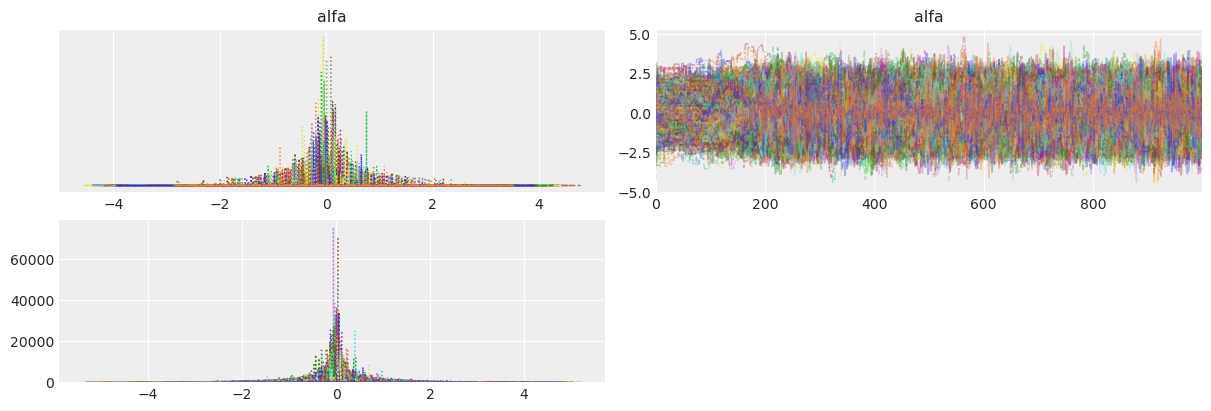

In [6]:
%%time
with pm.Model() as model:
    X_data = pm.Data('X_data', x_s)
    y_obs_data = pm.Data('y_obs_data', y_obs, mutable=True)

    # Priors for unknown model parameters
    alfa = pm.Normal('alfa', mu=0, sigma=1, shape=nclass)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=(nparam, nclass))
    mu = tt.dot(X_data, beta) + alfa
    p = tt.nnet.softmax(mu)
    #yl = pm.Categorical('obs', p=p, observed=y_obs_data)

    # Likelihood (sampling distribution) of observations
    #yl = pm.Normal('obs', rng=rng, dims=2, observed=y_obs_data)

    trace = pm.sample(draws=6000, tune=6000, target_accept = 0.8)
       
    #idata = az.from_pymc(trace)
    #pm.traceplot(idata)
    # PyMC’s pm.sample() now returns an arviz InferenceData object by default. So your trace variable is already what you want.
    # https://discourse.pymc.io/t/what-happened-to-az-from-pymc/12201

    # sample from the prior
    idata = pm.sample_prior_predictive()
    
az.summary(idata, kind="stats")
    
with model:
    # sample from the posterior predictive and add to the existing idata object
    idata.extend(pm.sample())
    # pm.traceplot(idata)
    # The function `traceplot` from PyMC was an alias for `plot_trace` from ArviZ. It was removed in PyMC 4.0. Switch to `pymc.plot_trace` or `arviz.plot_trace`.
    az.plot_trace(idata)
    

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 1044 seconds.
The acceptance probability does not match the target. It is 0.7166, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8011, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.818, but should be close to 0.9. Try to increase the number of tuning steps.